In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

# 6.5 Lab 1: Subset Selection Methods

**6.5.1 Best Subset Selection**

> library(ISLR)

> fix(Hitters)

> names(Hitters)

> dim(Hitters)

> sum(is.na(Hitters$Salary))

In [3]:
Hitters = pd.read_csv("data/Hitters.csv")
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
Hitters.shape

(322, 20)

In [5]:
Hitters.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

> Hitters=na.omit(Hitters)

> dim(Hitters)

> sum(is.na(Hitters))

In [6]:
Hitters_dropna = Hitters.dropna()

In [7]:
Hitters_dropna.shape

(263, 20)

In [8]:
Hitters_dropna.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

> library(leaps)

> regfit.full=regsubsets (Salary∼.,Hitters)

> summary(regfit.full)

In [9]:
#实现一个按照RSS（或者其他评估）来量化的regsubsets函数
import itertools
def regsubsets(model,dataset,nvmax = 8,method = 'full',scale = 'rss'):
    y,X = patsy.dmatrices(model, data = dataset, return_type="dataframe")
    X_columns = list(X.columns)
    try:
        X_columns.remove('Intercept')
    except:
        pass
    if nvmax > len(X_columns):
        nvmax = len(X_columns)
    all_data_dict = {}
    if method == 'full':
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            for X_columns_nv in itertools.combinations(X_columns,nv):
                X_columns_nv = list(X_columns_nv)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
    elif method == 'forward':
        all_data_dict[0] = {}
        all_data_dict[0]['X_columns'] = []
        for nv in range(1,nvmax + 1):
            nv_scale = None
            nv_result = {}
            X_columns_others = X_columns.copy()
            for column_value in all_data_dict[nv - 1]['X_columns']:
                X_columns_others.remove(column_value)
            for column_value in X_columns_others:
                X_columns_nv = all_data_dict[nv - 1]['X_columns'].copy()
                X_columns_nv.append(column_value)
                X_model = sm.add_constant(X[X_columns_nv])
                results = sm.OLS(y, X_model).fit()
                nv_result['rss'] = results.ssr
                nv_result['rsq'] = -results.rsquared
                nv_result['adjr2'] = -results.rsquared_adj
                nv_result['cp'] = results.aic
                nv_result['bic'] = results.bic
                if nv_scale == None or nv_scale > nv_result[scale]:
                    nv_scale = nv_result[scale]
                    nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        del all_data_dict[0]
    elif method == 'backward':
        for nv in reversed(range(1,len(X_columns) + 1)):
            nv_scale = None
            nv_result = {}
            if nv == len(X_columns):
                nv_X_columns = X_columns
            else:
                for column_value in all_data_dict[nv + 1]['X_columns']:
                    X_columns_nv = all_data_dict[nv + 1]['X_columns'].copy()
                    X_columns_nv.remove(column_value)
                    X_model = sm.add_constant(X[X_columns_nv])
                    results = sm.OLS(y, X_model).fit()
                    nv_result['rss'] = results.ssr
                    nv_result['rsq'] = -results.rsquared
                    nv_result['adjr2'] = -results.rsquared_adj
                    nv_result['cp'] = results.aic
                    nv_result['bic'] = results.bic
                    if nv_scale == None or nv_scale > nv_result[scale]:
                        nv_scale = nv_result[scale]
                        nv_X_columns = X_columns_nv
            X_model = sm.add_constant(X[nv_X_columns])
            results = sm.OLS(y, X_model).fit()
            all_data_dict[nv] = {}
            all_data_dict[nv]['X_columns'] = nv_X_columns
            all_data_dict[nv]['rss'] = results.ssr
            all_data_dict[nv]['rsq'] = results.rsquared
            all_data_dict[nv]['adjr2'] = results.rsquared_adj
            all_data_dict[nv]['cp'] = results.aic
            all_data_dict[nv]['bic'] = results.bic
            all_data_dict[nv]['params'] = results.params
        for nv in range(nvmax + 1,len(X_columns) + 1):
            del all_data_dict[nv]
    return pd.DataFrame(all_data_dict).T.sort_index()     

In [10]:
columns_value = '1'
for column_value in Hitters_dropna.columns:
    columns_value = columns_value + '+' + column_value
model = 'Salary ~ {} - Salary'.format(columns_value)
reg = regsubsets(model,Hitters_dropna)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
reg['X_columns']

1                                               [CRBI]
2                                         [Hits, CRBI]
3                                [Hits, CRBI, PutOuts]
4                 [Division[T.W], Hits, CRBI, PutOuts]
5          [Division[T.W], AtBat, Hits, CRBI, PutOuts]
6    [Division[T.W], AtBat, Hits, Walks, CRBI, PutO...
7    [Division[T.W], Hits, Walks, CAtBat, CHits, CH...
8    [Division[T.W], AtBat, Hits, Walks, CHmRun, CR...
Name: X_columns, dtype: object

> regfit.full=regsubsets (Salary∼.,data=Hitters ,nvmax=19)

> reg.summary=summary(regfit.full)

In [12]:
reg_full = regsubsets(model,Hitters_dropna,19)
reg_full['X_columns']

1                                                [CRBI]
2                                          [Hits, CRBI]
3                                 [Hits, CRBI, PutOuts]
4                  [Division[T.W], Hits, CRBI, PutOuts]
5           [Division[T.W], AtBat, Hits, CRBI, PutOuts]
6     [Division[T.W], AtBat, Hits, Walks, CRBI, PutO...
7     [Division[T.W], Hits, Walks, CAtBat, CHits, CH...
8     [Division[T.W], AtBat, Hits, Walks, CHmRun, CR...
9     [Division[T.W], AtBat, Hits, Walks, CAtBat, CR...
10    [Division[T.W], AtBat, Hits, Walks, CAtBat, CR...
11    [League[T.N], Division[T.W], AtBat, Hits, Walk...
12    [League[T.N], Division[T.W], AtBat, Hits, Runs...
13    [League[T.N], Division[T.W], AtBat, Hits, Runs...
14    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
15    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
16    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
17    [League[T.N], Division[T.W], NewLeague[T.N], A...
18    [League[T.N], Division[T.W], NewLeague[T.N

In [13]:
#> reg.summary$rsq
reg_full['rsq']

1      0.32145
2     0.425224
3     0.451429
4     0.475407
5     0.490804
6     0.508715
7     0.514123
8     0.528557
9     0.534612
10    0.540495
11    0.542615
12     0.54363
13    0.544457
14    0.545216
15    0.545469
16    0.545766
17    0.545952
18    0.546095
19    0.546116
Name: rsq, dtype: object

> par(mfrow=c(2,2))

> plot(reg.summary$rss ,xlab="Number of Variables ",ylab="RSS",
type="l")

> plot(reg.summary$adjr2 ,xlab="Number of Variables ",
ylab="Adjusted RSq",type="l")

> points(11,reg.summary$adjr2[11], col="red",cex=2,pch=20)

> plot(reg.summary$cp ,xlab="Number of Variables ",ylab="Cp",
type=’l’)

> points(10,reg.summary$cp [10],col="red",cex=2,pch=20)

> plot(reg.summary$bic ,xlab="Number of Variables ",ylab="BIC",
type=’l’)

> points(6,reg.summary$bic [6],col="red",cex=2,pch=20)


In [14]:
test = reg_full['adjr2']

In [15]:
test.astype('float')

1     0.318850
2     0.420802
3     0.445075
4     0.467273
5     0.480897
6     0.497200
7     0.500785
8     0.513708
9     0.518057
10    0.522261
11    0.522571
12    0.521724
13    0.520674
14    0.519543
15    0.517866
16    0.516222
17    0.514446
18    0.512610
19    0.510627
Name: adjr2, dtype: float64

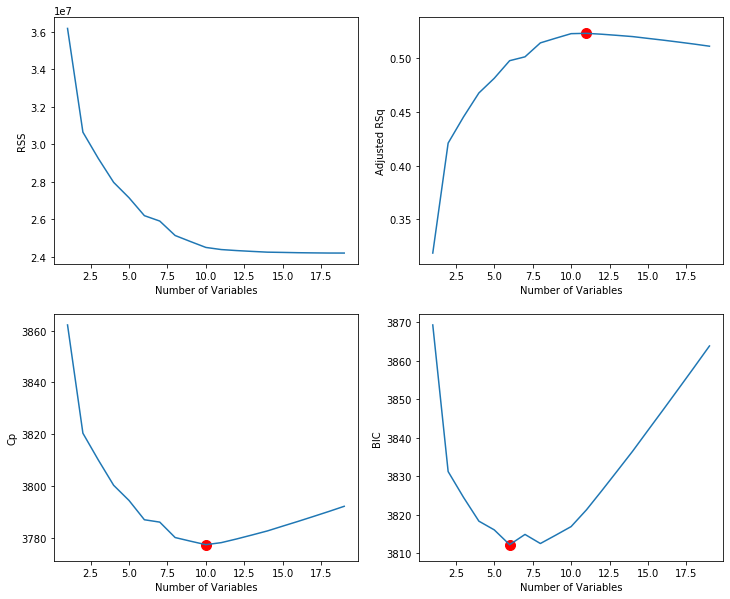

In [16]:
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(reg_full['rss'])
plt.xlabel(u"Number of Variables")
plt.ylabel(u"RSS")
plt.subplot(222)
plt.plot(reg_full['adjr2'])
plt.xlabel(u"Number of Variables")
plt.ylabel(u"Adjusted RSq")
Arsq_max = reg_full['adjr2'].astype('float').idxmax()
plt.scatter(Arsq_max,reg_full['adjr2'][Arsq_max],color = 'red',s=100,marker='o')
plt.subplot(223)
plt.plot(reg_full['cp'])
plt.xlabel(u"Number of Variables")
plt.ylabel(u"Cp")
Cp_min = reg_full['cp'].astype('float').idxmin()
plt.scatter(Cp_min,reg_full['cp'][Cp_min],color = 'red',s=100,marker='o')
plt.subplot(224)
plt.plot(reg_full['bic'])
plt.xlabel(u"Number of Variables")
plt.ylabel(u"BIC")
BIC_min = reg_full['bic'].astype('float').idxmin()
plt.scatter(BIC_min,reg_full['bic'][BIC_min],color = 'red',s=100,marker='o')
plt.show()

> coef(regfit.full ,6)

In [17]:
reg_full['params'][BIC_min]

const             91.511798
Division[T.W]   -122.951534
AtBat             -1.868589
Hits               7.604398
Walks              3.697647
CRBI               0.643017
PutOuts            0.264308
dtype: float64

**6.5.2 Forward and Backward Stepwise Selection**

> regfit.fwd=regsubsets (Salary∼.,data=Hitters ,nvmax=19,
method="forward ")

> summary(regfit.fwd)

> regfit.bwd=regsubsets (Salary∼.,data=Hitters ,nvmax=19,
method="backward ")

> summary(regfit.bwd)

In [18]:
reg_fwd = regsubsets(model,Hitters_dropna, nvmax = 19, method =  'forward')
reg_fwd['X_columns']

1                                                [CRBI]
2                                          [CRBI, Hits]
3                                 [CRBI, Hits, PutOuts]
4                  [CRBI, Hits, PutOuts, Division[T.W]]
5           [CRBI, Hits, PutOuts, Division[T.W], AtBat]
6     [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
7     [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
8     [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
9     [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
10    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
11    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
12    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
13    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
14    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
15    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
16    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
17    [CRBI, Hits, PutOuts, Division[T.W], AtBat, Wa...
18    [CRBI, Hits, PutOuts, Division[T.W], AtBat

In [19]:
reg_bwd = regsubsets(model,Hitters_dropna, nvmax = 19, method =  'backward')
reg_bwd['X_columns']

1                                               [CRuns]
2                                         [Hits, CRuns]
3                                [Hits, CRuns, PutOuts]
4                         [AtBat, Hits, CRuns, PutOuts]
5                  [AtBat, Hits, Walks, CRuns, PutOuts]
6     [Division[T.W], AtBat, Hits, Walks, CRuns, Put...
7     [Division[T.W], AtBat, Hits, Walks, CRuns, CWa...
8     [Division[T.W], AtBat, Hits, Walks, CRuns, CRB...
9     [Division[T.W], AtBat, Hits, Walks, CAtBat, CR...
10    [Division[T.W], AtBat, Hits, Walks, CAtBat, CR...
11    [League[T.N], Division[T.W], AtBat, Hits, Walk...
12    [League[T.N], Division[T.W], AtBat, Hits, Runs...
13    [League[T.N], Division[T.W], AtBat, Hits, Runs...
14    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
15    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
16    [League[T.N], Division[T.W], AtBat, Hits, HmRu...
17    [League[T.N], Division[T.W], NewLeague[T.N], A...
18    [League[T.N], Division[T.W], NewLeague[T.N

> coef(regfit.full ,7)

> coef(regfit.fwd ,7)

> coef(regfit.bwd ,7)

In [20]:
reg_full['params'][7]

const             79.450947
Division[T.W]   -129.986643
Hits               1.283351
Walks              3.227426
CAtBat            -0.375235
CHits              1.495707
CHmRun             1.442054
PutOuts            0.236681
dtype: float64

In [21]:
reg_fwd['params'][7]

const            109.787306
CRBI               0.853762
Hits               7.449877
PutOuts            0.253340
Division[T.W]   -127.122393
AtBat             -1.958885
Walks              4.913140
CWalks            -0.305307
dtype: float64

In [22]:
reg_bwd['params'][7]

const            105.648749
Division[T.W]   -116.169217
AtBat             -1.976284
Hits               6.757491
Walks              6.055869
CRuns              1.129309
CWalks            -0.716335
PutOuts            0.302885
dtype: float64

**6.5.3 Choosing Among Models Using the Validation Set
Approach and Cross-Validation**

> set.seed(1)

> train=sample(c(TRUE,FALSE), nrow(Hitters),rep=TRUE)

> test=(!train)

In [23]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Hitters_dropna, test_size = 0.5, random_state = 1)

In [24]:
#> regfit.best=regsubsets (Salary∼.,data=Hitters[train ,],nvmax=19)
regfit_best = regsubsets(model, train_set, nvmax = 19)

In [25]:
#> test.mat=model.matrix(Salary∼.,data=Hitters[test ,])
y_test ,X_test = patsy.dmatrices(model,test_set, return_type="dataframe")

> val.errors=rep(NA,19)

> for(i in 1:19){
+ coefi=coef(regfit.best ,id=i)
+ pred=test.mat[,names(coefi)]%*%coefi
+ val.errors[i]=mean((Hitters$Salary[test]-pred)^2)
}

> val.errors

In [26]:
def regfit_var_errors(regfit,train_set,test_set,model):
    nvmax = len(regfit)
    y_train ,X_train = patsy.dmatrices(model,train_set, return_type="dataframe")
    y_test ,X_test = patsy.dmatrices(model,test_set, return_type="dataframe")
    var_errors = {}
    for nv in range(1,nvmax + 1):
        X_train_model = sm.add_constant(X_train[regfit['X_columns'][nv]])
        results = sm.OLS(y_train,X_train_model).fit()
        predict_test = results.predict(sm.add_constant(X_test[regfit['X_columns'][nv]]))
        var_errors[nv] = ((np.c_[y_test].ravel() - predict_test)**2).mean()     
    return pd.DataFrame(var_errors,index = ['var_errors']).round().T
var_errors = regfit_var_errors(regfit_best,train_set,test_set,model)
var_errors

,var_errors
1,118362.0
2,130967.0
3,119625.0
4,134908.0
5,112643.0
6,107271.0
7,116459.0
8,106841.0
9,105174.0
10,106398.0


In [27]:
#> which.min(val.errors)
var_errors.idxmin()

var_errors    9
dtype: int64

In [28]:
#> coef(regfit.best ,10)
regfit_best['params'][var_errors.idxmin()[0]]

const            268.566390
Division[T.W]   -125.778852
AtBat             -1.972139
Hits               5.773220
Walks              4.363040
CAtBat            -0.457920
CHits              1.713801
CHmRun             2.122356
PutOuts            0.399087
Assists            0.246362
dtype: float64

> regfit.best=regsubsets (Salary∼.,data=Hitters ,nvmax=19)

> coef(regfit.best ,10)

In [29]:
reg_full['params'][var_errors.idxmin()[0]]

const            146.249600
Division[T.W]   -115.349501
AtBat             -1.936768
Hits               6.656721
Walks              5.552044
CAtBat            -0.099539
CRuns              1.250671
CRBI               0.661768
CWalks            -0.777985
PutOuts            0.277731
dtype: float64

> k=10

> set.seed(1)

> folds=sample(1:k,nrow(Hitters),replace=TRUE)

> cv.errors=matrix(NA,k,19, dimnames =list(NULL , paste(1:19)))

> for(j in 1:k){
+ best.fit=regsubsets (Salary∼.,data=Hitters[folds!=j,],
nvmax=19)
+ for(i in 1:19){
+ pred=predict(best.fit ,Hitters[folds==j,],id=i)
+ cv.errors[j,i]=mean( (Hitters$Salary[folds==j]-pred)^2)
+ }
+ }

In [30]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=1,shuffle=True)
kf.get_n_splits(Hitters_dropna)

10

In [31]:
var_errors_kf = pd.DataFrame()
kf_idx = 1
for train_index, test_index in kf.split(Hitters_dropna):
    regfit_best = regsubsets(model, Hitters_dropna.iloc[train_index], nvmax = 19)
    var_errors = regfit_var_errors(regfit_best, Hitters_dropna.iloc[train_index],Hitters_dropna.iloc[test_index],model)
    var_errors_kf['kf_idx{}'.format(kf_idx)] = var_errors['var_errors']
    kf_idx += 1

> mean.cv.errors=apply(cv.errors ,2,mean)

> mean.cv.errors

In [32]:
var_errors_kf.T.mean()

1     146418.0
2     127083.0
3     138197.4
4     139002.3
5     130911.7
6     126773.7
7     124909.5
8     115740.9
9     114953.5
10    109200.1
11    108635.0
12    112886.0
13    114225.1
14    115740.5
15    116610.5
16    116947.7
17    116980.2
18    117030.2
19    117027.3
dtype: float64

> par(mfrow=c(1,1))

> plot(mean.cv.errors ,type=’b’)

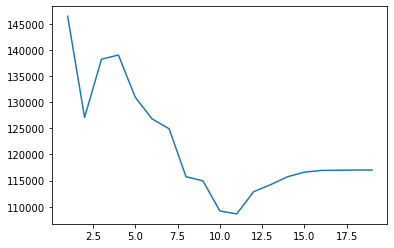

In [33]:
plt.plot(var_errors_kf.T.mean())
plt.show()

> reg.best=regsubsets (Salary∼.,data=Hitters , nvmax=19)

> coef(reg.best ,11)

In [34]:
reg_full['params'][var_errors_kf.T.mean().idxmin()]

const            135.751219
League[T.N]       43.111615
Division[T.W]   -111.146025
AtBat             -2.127748
Hits               6.923699
Walks              5.620276
CAtBat            -0.138991
CRuns              1.455331
CRBI               0.785253
CWalks            -0.822856
PutOuts            0.289409
Assists            0.268828
dtype: float64

**使用sklearn的递归特征消除进行特征选择效率更高**

In [35]:
from sklearn.feature_selection import RFECV
y ,X = patsy.dmatrices(model, Hitters_dropna, return_type="dataframe")
estimator = linear_model.LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X, np.c_[y].ravel())
selector.support_

array([False,  True,  True,  True, False,  True,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False])

In [36]:
pd.DataFrame(selector.support_,index = X.columns).T

,Intercept,League[T.N],Division[T.W],NewLeague[T.N],AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,False,True,True,True,False,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False


**使用RFE和GridSearchCV效果不佳**

In [37]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_features_to_select': np.linspace(1, 19, 19) },
]
lr =linear_model.LinearRegression()
rfe = RFE(estimator=lr)
grid_search = GridSearchCV(rfe, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X, np.c_[y].ravel())

GridSearchCV(cv=10, error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19.])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [38]:
grid_search.best_params_

{'n_features_to_select': 19.0}

# 6.6 Lab 2: Ridge Regression and the Lasso

> x=model.matrix(Salary∼.,Hitters)[,-1]

> y=Hitters$Salary

In [39]:
y ,X = patsy.dmatrices(model, Hitters_dropna, return_type="dataframe")
X.drop('Intercept',axis = 1,inplace = True)

**6.6.1 Ridge Regression**

> library(glmnet)

> grid=10^seq(10,-2, length =100)

> ridge.mod=glmnet(x,y,alpha=0,lambda=grid)

In [40]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
#python与R的大致比例，这里不知道是怎么算出来的
division_belta = 1.7126565947819132
grid = 10 ** np.linspace(10, -2, 100)/division_belta
def get_shrinkage_mod(X,y,grid,methods = 1,return_type = 1):
    std_scaler = StandardScaler(with_mean = False)
    std_scaler.fit(X)
    X_Standard = std_scaler.transform(X)
    shrinkage_mod =  []
    idx = 1
    shrinkage_mod_columns = [['idx','lambda','coef'],['','','Intercept']]
    for variable in X.columns:
        shrinkage_mod_columns[0].append('coef')
        shrinkage_mod_columns[1].append(variable)
    for alpha in grid:
        if methods == 1:
            shrinkage_reg = Ridge(alpha = alpha)
        else:
            shrinkage_reg = Lasso(alpha = alpha)           
        shrinkage_reg.fit(X_Standard,y)
        shrinkage_mod.append([])
        shrinkage_mod[idx - 1].append(idx)
        shrinkage_mod[idx - 1].append(alpha)
        shrinkage_mod[idx - 1].append(shrinkage_reg.intercept_[0])
        #return_type为1返回Standardized Coefficients，否则反馈原模型的Coefficients
        if return_type == 1:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_[0])
            else:
                shrinkage_mod[idx - 1].extend(shrinkage_reg.coef_)
        else:
            if methods == 1:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_[0].reshape(1,-1))[0].tolist())
            else:
                shrinkage_mod[idx - 1].extend(std_scaler.transform(shrinkage_reg.coef_.reshape(1,-1))[0].tolist())
        idx += 1
    return  pd.DataFrame(np.array(shrinkage_mod),columns = shrinkage_mod_columns).set_index('idx')
ridge_mod = get_shrinkage_mod(X,y,grid,return_type = 2)

In [41]:
#> dim(coef(ridge.mod))
ridge_mod['coef'].shape

(100, 20)

In [42]:
#> ridge.mod$lambda [50],python与R的大致比例为division_belta，这里不知道是怎么算出来的
ridge_mod['lambda'][50]

6713.295583602641

In [43]:
#> coef(ridge.mod)[,50]
ridge_mod['coef'].loc[50]

Intercept         407.318320
League[T.N]         0.085222
Division[T.W]      -6.217585
NewLeague[T.N]      0.301652
AtBat               0.036968
Hits                0.138222
HmRun               0.524777
Runs                0.230770
RBI                 0.239911
Walks               0.289705
Years               1.108004
CAtBat              0.003133
CHits               0.011657
CHmRun              0.087571
CRuns               0.023387
CRBI                0.024145
CWalks              0.025023
PutOuts             0.016488
Assists             0.002614
Errors             -0.020513
Name: 50.0, dtype: float64

In [44]:
#> sqrt(sum(coef(ridge.mod)[-1,50]^2) )
((ridge_mod['coef'].loc[50].iloc[1:])**2).sum()**0.5

6.36279523335839

In [45]:
#> ridge.mod$lambda [60],python与R的大致比例为division_belta，这里不知道是怎么算出来的
ridge_mod['lambda'][60]

411.921592

In [46]:
#> coef(ridge.mod)[,60]
ridge_mod['coef'].loc[60]

Intercept         54.325000
League[T.N]       13.684100
Division[T.W]    -54.671166
NewLeague[T.N]     8.611493
AtBat              0.111978
Hits               0.655899
HmRun              1.178235
Runs               0.937760
RBI                0.847394
Walks              1.320365
Years              2.593182
CAtBat             0.010846
CHits              0.046815
CHmRun             0.338224
CRuns              0.093594
CRBI               0.097762
CWalks             0.071794
PutOuts            0.118554
Assists            0.016090
Errors            -0.703184
Name: 60.0, dtype: float64

In [47]:
#> sqrt(sum(coef(ridge.mod)[-1,60]^2) )
((ridge_mod['coef'].loc[60].iloc[1:])**2).sum()**0.5

57.12174816376263

In [48]:
#> predict(ridge.mod,s=50,type="coefficients")[1:20,]
get_shrinkage_mod(X,y,[50/division_belta ],return_type = 2)['coef'].iloc[0]

Intercept          47.739713
League[T.N]        45.849355
Division[T.W]    -118.221187
NewLeague[T.N]     -9.390502
AtBat              -0.352716
Hits                1.954027
HmRun              -1.273758
Runs                1.156011
RBI                 0.809037
Walks               2.704833
Years              -6.123260
CAtBat              0.006045
CHits               0.106013
CHmRun              0.621248
CRuns               0.216478
CRBI                0.217319
CWalks             -0.146943
PutOuts             0.250112
Assists             0.120516
Errors             -3.277705
Name: 1.0, dtype: float64

> set.seed(1)

> train=sample(1:nrow(x), nrow(x)/2)

> test=(-train)

> y.test=y[test]

In [49]:
train_set, test_set = train_test_split(Hitters_dropna, test_size = 0.5, random_state = 1)
y_train ,X_train = patsy.dmatrices(model, train_set, return_type="dataframe")
y_test ,X_test = patsy.dmatrices(model, test_set, return_type="dataframe")
#在sklearn中默认fit_intercept=True，默认不要在X初始模型中代入Intercept，故而model用0+开头
X_train_original = X_train.drop('Intercept',axis = 1)

> ridge.mod=glmnet(x[train ,],y[train],alpha=0,lambda=grid,
thresh=1e-12)

> ridge.pred=predict(ridge.mod,s=4,newx=x[test ,])

> mean((ridge.pred-y.test)^2)

In [50]:
ridge_mod = get_shrinkage_mod(X_train_original,y_train,[4],return_type = 2)
ridge_pred = (ridge_mod['coef'].iloc[0] * X_test).sum(axis = 1)
((y_test.T - ridge_pred) ** 2).mean(axis = 1)

Salary    102144.523951
dtype: float64

In [51]:
#> mean((mean(y[train])-y.test)^2)
((y_train.mean() - y_test)**2).mean()

Salary    172862.235921
dtype: float64

> ridge.pred=predict(ridge.mod,s=1e10,newx=x[test ,])

> mean((ridge.pred-y.test)^2)

In [52]:
ridge_mod = get_shrinkage_mod(X_train_original,y_train,[10 ** 10],return_type = 2)
ridge_pred = (ridge_mod['coef'].iloc[0] * X_test).sum(axis = 1)
((y_test.T - ridge_pred) ** 2).mean(axis = 1)

Salary    172862.220592
dtype: float64

> ridge.pred=predict(ridge.mod,s=0,newx=x[test ,],exact=T)

> mean((ridge.pred-y.test)^2)

> lm(y∼x, subset=train)

> predict(ridge.mod,s=0,exact=T,type="coefficients")[1:20,]

In [53]:
ridge_mod = get_shrinkage_mod(X_train_original,y_train,[0],return_type = 2)
ridge_pred = (ridge_mod['coef'].iloc[0] * X_test).sum(axis = 1)
((y_test.T - ridge_pred) ** 2).mean(axis = 1)

Salary    116690.468567
dtype: float64

In [54]:
get_shrinkage_mod(X_train_original,y_train,[0],return_type = 2)['coef'].iloc[0]

Intercept         231.163321
League[T.N]       133.743163
Division[T.W]    -113.743875
NewLeague[T.N]    -81.927763
AtBat              -1.821115
Hits                4.259156
HmRun              -4.773401
Runs               -0.038760
RBI                 3.984578
Walks               3.470126
Years               9.498236
CAtBat             -0.605129
CHits               2.174979
CHmRun              2.979306
CRuns               0.266356
CRBI               -0.598456
CWalks              0.171383
PutOuts             0.421063
Assists             0.464379
Errors             -6.024576
Name: 1.0, dtype: float64

In [55]:
result = smf.ols(model,train_set).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     9.195
Date:                Sat, 04 Jan 2020   Prob (F-statistic):           3.08e-15
Time:                        09:11:13   Log-Likelihood:                -933.41
No. Observations:                 131   AIC:                             1907.
Df Residuals:                     111   BIC:                             1964.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        231.1633    137.543      1.681      0.096     -41.387     503.713
League[T.N]      133.7432    144.622      0.925      0.357    -152.835     420.321
Division[T.W]   -113.7439     61.965     -1.836      0.069    -236.532       9.045
NewLeague[T.N]   -81.9278    142.959     -0.573      0.568    -365.210     201.354
AtBat             -1.8211      1.031     -1.766      0.080      -3.865       0.222
Hits               4.2592      3.998      1.065      0.289      -3.663      12.181
HmRun             -4.7734      9.939     -0.480      0.632     -24.468      14.921
Runs              -0.0388      4.542     -0.009      0.993      -9.039       8.961
RBI                3.9846      4.080      0.977      0.331      -4.101      12.070
Walks              3.4701      2.786      1.245      0.216      -2.051       8.992
Years              9.4982     19.381      0.490      0.625     -28.907      47.903
CAtBat            -0.6051      0.248     -2.436      0.016      -1.097      -0.113
CHits              2.1750      1.358      1.602      0.112      -0.515       4.865
CHmRun             2.9793      2.807      1.061      0.291      -2.583       8.542
CRuns              0.2664      1.280      0.208      0.836      -2.270       2.802
CRBI              -0.5985      1.277     -0.469      0.640      -3.129       1.932
CWalks             0.1714      0.575      0.298      0.766      -0.969       1.311
PutOuts            0.4211      0.117      3.589      0.000       0.189       0.654
Assists            0.4644      0.375      1.238      0.218      -0.279       1.208
Errors            -6.0246      7.414     -0.813      0.418     -20.716       8.667
==============================================================================
Omnibus:                       58.408   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.832
Skew:                           1.332   Prob(JB):                     3.36e-88
Kurtosis:                      11.167   Cond. No.                     2.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> set.seed(1)

> cv.out=cv.glmnet(x[train ,],y[train],alpha=0)

> plot(cv.out)

> bestlam=cv.out$lambda .min

> bestlam

In [56]:
from sklearn.model_selection import GridSearchCV
std_scaler = StandardScaler(with_mean=False)
std_scaler.fit(X_train_original)
X_train_Standard = std_scaler.transform(X_train_original)
param_grid = [
{'alpha': 10 ** np.linspace(10, -2, 100) },
]
ridge_reg = Ridge(random_state = 1)
grid_search = GridSearchCV(ridge_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=1,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e...
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

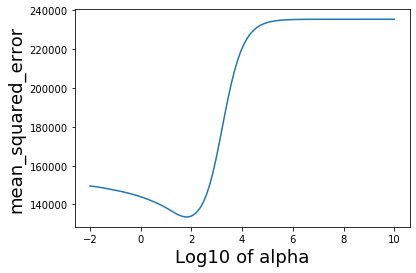

In [57]:
plt.plot(np.linspace(10, -2, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [58]:
grid_search.best_params_

{'alpha': 57.223676593502205}

In [59]:
grid_search.best_score_

-133581.19172431607

> ridge.pred=predict(ridge.mod,s=bestlam ,newx=x[test ,])

> mean((ridge.pred-y.test)^2)

In [60]:
ridge_mod = get_shrinkage_mod(X_train_original,y_train,[grid_search.best_params_['alpha']],return_type = 2)
ridge_pred = (ridge_mod['coef'].iloc[0] * X_test).sum(axis = 1)
((y_test.T - ridge_pred) ** 2).mean(axis = 1)

Salary    100168.963546
dtype: float64

> out=glmnet(x,y,alpha=0)

> predict(out,type="coefficients",s=bestlam)[1:20,]

In [61]:
ridge_mod['coef'].iloc[0]

Intercept         13.234316
League[T.N]       21.566186
Division[T.W]    -99.920322
NewLeague[T.N]     8.721308
AtBat             -0.064012
Hits               0.969434
HmRun             -0.860147
Runs               0.681396
RBI                1.405297
Walks              2.272420
Years              0.527110
CAtBat             0.005162
CHits              0.054679
CHmRun             0.561064
CRuns              0.111796
CRBI               0.139866
CWalks             0.091984
PutOuts            0.304977
Assists           -0.014558
Errors            -0.532257
Name: 1.0, dtype: float64

6.6.2 lasso

> lasso.mod=glmnet(x[train ,],y[train],alpha=1,lambda=grid)

> plot(lasso.mod)

In [62]:
lasso_mod = get_shrinkage_mod(X_train_original,y_train,grid,methods = 2,return_type = 2)

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6676.572101525962, tolerance: 3050.401923222197
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11572.810117574409, tolerance: 3050.401923222197
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48327.31088923104, tolerance: 3050.401923222197
  positive)
c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_d

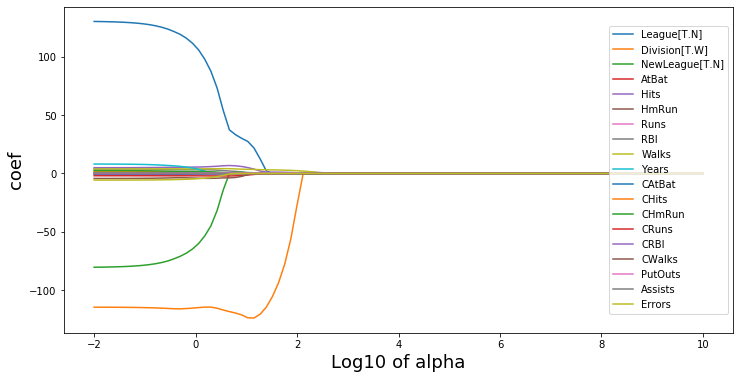

In [63]:
plt.figure(figsize=(12, 6))
for coef in X_train_original.columns:
    plt.plot(np.linspace(10, -2, 100),lasso_mod['coef'][coef],label = coef)
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("coef", fontsize=18)
plt.legend(loc='right')
plt.show()

> set.seed(1)

> cv.out=cv.glmnet(x[train ,],y[train],alpha=1)

> plot(cv.out)

> bestlam=cv.out$lambda .min

> lasso.pred=predict(lasso.mod,s=bestlam ,newx=x[test ,])

> mean((lasso.pred-y.test)^2)

In [64]:
Lasso_reg = Lasso(random_state = 1,max_iter=100000)
grid_search = GridSearchCV(Lasso_reg, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_Standard ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=100000, normalize=False, positive=False,
                             precompute=False, random_state=1,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09...
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

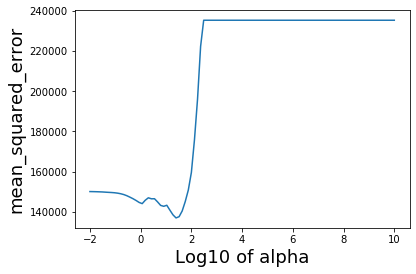

In [65]:
plt.plot(np.linspace(10, -2, 100),-grid_search.cv_results_["mean_test_score"])
plt.xlabel("Log10 of alpha", fontsize=18)
plt.ylabel("mean_squared_error", fontsize=18)
plt.show()

In [66]:
grid_search.best_params_

{'alpha': 24.77076355991714}

In [67]:
grid_search.best_score_

-136954.49840405435

In [68]:
lasso_mod = get_shrinkage_mod(X_train_original,y_train,[grid_search.best_params_['alpha']],methods = 2,return_type = 2)
lasso_pred = (lasso_mod['coef'].iloc[0] * X_test).sum(axis = 1)
((y_test.T - lasso_pred) ** 2).mean(axis = 1)

Salary    104808.743162
dtype: float64

> out=glmnet(x,y,alpha=1,lambda=grid)

> lasso.coef=predict(out,type="coefficients",s=bestlam)[1:20,]

> lasso.coef

In [69]:
lasso_mod['coef'].iloc[0]

Intercept         47.560195
League[T.N]        0.000000
Division[T.W]    -94.335926
NewLeague[T.N]     0.000000
AtBat              0.000000
Hits               1.103637
HmRun              0.000000
Runs               0.000000
RBI                0.000000
Walks              2.950612
Years              0.000000
CAtBat             0.000000
CHits              0.000000
CHmRun             0.231397
CRuns              0.000000
CRBI               0.517073
CWalks             0.000000
PutOuts            0.372854
Assists           -0.000000
Errors            -0.000000
Name: 1.0, dtype: float64

In [70]:
lasso_mod['coef'].iloc[0][lasso_mod['coef'].iloc[0] != 0]

Intercept        47.560195
Division[T.W]   -94.335926
Hits              1.103637
Walks             2.950612
CHmRun            0.231397
CRBI              0.517073
PutOuts           0.372854
Name: 1.0, dtype: float64

# 6.7 Lab 3: PCR and PLS Regression

**6.7.1 Principal Components Regression**

> library(pls)

> set.seed(2)

> pcr.fit=pcr(Salary∼., data=Hitters ,scale=TRUE, validation ="CV")

In [71]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
np.random.seed(2)
pca_lr = Pipeline([
("std_scaler", StandardScaler(with_mean=False)),
("pca", PCA()),
("lr", linear_model.LinearRegression())
])
param_grid = [
{'pca__n_components': np.arange(1,20) },
]
grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X ,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
        

In [72]:
# > summary(pcr.fit}
# Cross -validated using 10 random segments，缺少(Intercept )相当于0 component，原因为PCA不支持，这里单独添加
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=10, random_state=2,shuffle=True)
kf.get_n_splits(Hitters_dropna)
intercept_mse = []
for train_index, test_index in kf.split(Hitters_dropna):
    y_train_cv ,X_train_cv = patsy.dmatrices(model, Hitters_dropna.iloc[train_index], return_type="dataframe")
    y_test_cv ,X_test_cv = patsy.dmatrices(model, Hitters_dropna.iloc[train_index], return_type="dataframe")
    lr = linear_model.LinearRegression()
    lr.fit(np.zeros((len(X_train_cv),1)),y_train_cv)
    intercept_mse.append(mean_squared_error(lr.predict(np.zeros((len(X_test_cv),1))),y_test_cv))
scores_list = [-np.mean(intercept_mse)]
params_list = [{'pca__n_components': 0}]
#以上为添加(Intercept )段，以下为根据grid_search得到的1-19 component
cvres = grid_search.cv_results_
scores_list.extend(cvres["mean_test_score"])
params_list.extend(cvres["params"])
mean_score_list = []
for mean_score, params in zip(scores_list, params_list):
    print(np.sqrt(-mean_score), params)
    mean_score_list.append(np.sqrt(-mean_score))

450.0942661755781 {'pca__n_components': 0}
352.7767257441136 {'pca__n_components': 1}
354.24814883789435 {'pca__n_components': 2}
355.4150999695135 {'pca__n_components': 3}
351.306794593296 {'pca__n_components': 4}
347.339710721479 {'pca__n_components': 5}
344.5781603032924 {'pca__n_components': 6}
344.92594488126684 {'pca__n_components': 7}
346.05648451631384 {'pca__n_components': 8}
346.61231651340586 {'pca__n_components': 9}
349.3731005632004 {'pca__n_components': 10}
350.39271128095356 {'pca__n_components': 11}
351.943806487832 {'pca__n_components': 12}
352.585490059155 {'pca__n_components': 13}
345.06258063774413 {'pca__n_components': 14}
346.7118007253128 {'pca__n_components': 15}
341.4108478797464 {'pca__n_components': 16}
341.1119334988881 {'pca__n_components': 17}
339.19946588457316 {'pca__n_components': 18}
341.4659773298103 {'pca__n_components': 19}


In [73]:
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score
#续前TRAINING : % variance explained
columns_names = []
for i in range(1,20):
    columns_names.append(str(i) + ' comps')
pca_var_exp = pd.DataFrame(columns = columns_names)
pca=PCA(n_components = 19)
pca.fit(scale(X))
pca_var_exp.loc['X'] = (pca.explained_variance_ratio_.cumsum()*100).round(2)
Salary_var_exp = []
for n_components in range(1,20):
    pca_lr = Pipeline([
    ("std_scaler", StandardScaler(with_mean=False)),
    ("pca", PCA(n_components = n_components)),
    ("lr", linear_model.LinearRegression())
    ])
    pca_lr.fit(X ,y)
    Salary_var_exp.append(r2_score(y,pca_lr.predict(X)))
pca_var_exp.loc['Salary'] = (np.array(Salary_var_exp)*100).round(2) 
pca_var_exp

,1 comps,2 comps,3 comps,4 comps,5 comps,6 comps,7 comps,8 comps,9 comps,10 comps,11 comps,12 comps,13 comps,14 comps,15 comps,16 comps,17 comps,18 comps,19 comps
X,38.31,60.16,70.84,79.03,84.29,88.63,92.26,94.96,96.28,97.26,97.98,98.65,99.15,99.47,99.75,99.89,99.97,99.99,100.00
Salary,40.63,41.58,42.17,43.22,44.90,46.48,46.69,46.75,46.86,47.76,47.82,47.85,48.10,50.40,50.55,53.01,53.85,54.61,54.61


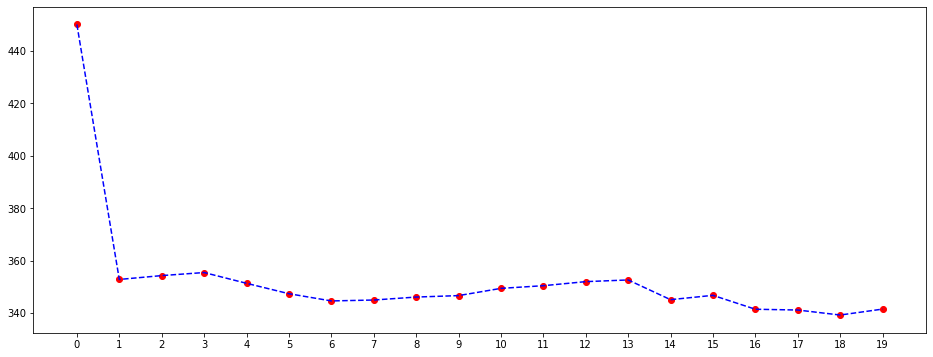

In [74]:
#> validationplot(pcr.fit,val.type="MSEP")
plt.figure(figsize=(16, 6))
plt.plot(range(20),mean_score_list,'b--')
plt.scatter(range(20),mean_score_list, marker = 'o',color = 'r')
plt.xticks((range(20)))
plt.show()

> set.seed(1)

> pcr.fit=pcr(Salary∼., data=Hitters ,subset=train ,scale=TRUE,
validation ="CV")

> validationplot(pcr.fit,val.type="MSEP")

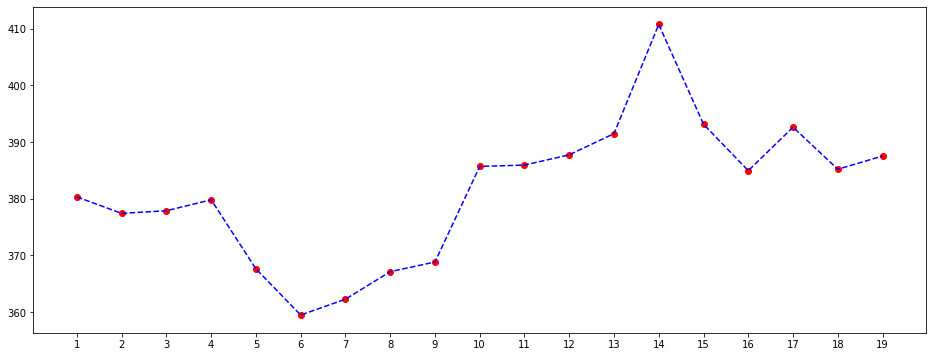

In [75]:
np.random.seed(1)
grid_search = GridSearchCV(pca_lr, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train ,y_train)
plt.figure(figsize=(16, 6))
plt.plot(range(1,20),np.sqrt(-grid_search.cv_results_["mean_test_score"]),'b--')
plt.scatter(range(1,20),np.sqrt(-grid_search.cv_results_["mean_test_score"]), marker = 'o',color = 'r')
plt.xticks((range(1,20)))
plt.show()

> pcr.pred=predict(pcr.fit ,x[test ,],ncomp=7)

> mean((pcr.pred-y.test)^2)

In [76]:
grid_search.best_params_

{'pca__n_components': 6}

In [77]:
mean_squared_error(grid_search.predict(X_test),y_test)

108195.7795746252

> pcr.fit=pcr(y∼x,scale=TRUE,ncomp=7)

> summary(pcr.fit)

In [78]:
#续前TRAINING : % variance explained
columns_names = []
for i in range(1,7):
    columns_names.append(str(i) + ' comps')
pca_var_exp = pd.DataFrame(columns = columns_names)
pca=PCA(n_components = 6)
pca.fit(scale(X))
pca_var_exp.loc['X'] = (pca.explained_variance_ratio_.cumsum()*100).round(2)
Salary_var_exp = []
for n_components in range(1,7):
    pca_lr = Pipeline([
    ("std_scaler", StandardScaler(with_mean=False)),
    ("pca", PCA(n_components = n_components)),
    ("lr", linear_model.LinearRegression())
    ])
    pca_lr.fit(X ,y)
    Salary_var_exp.append(r2_score(y,pca_lr.predict(X)))
pca_var_exp.loc['Salary'] = (np.array(Salary_var_exp)*100).round(2) 
pca_var_exp

,1 comps,2 comps,3 comps,4 comps,5 comps,6 comps
X,38.31,60.16,70.84,79.03,84.29,88.63
Salary,40.63,41.58,42.17,43.22,44.90,46.48


**6.7.2 Partial Least Squares**

> set.seed(1)

> pls.fit=plsr(Salary∼., data=Hitters ,subset=train ,scale=TRUE ,
validation ="CV")

> summary(pls.fit)

In [79]:
from sklearn.cross_decomposition import PLSRegression
np.random.seed(1)
param_grid = [
{'n_components': np.arange(1,20) },
]
pls = PLSRegression()
grid_search = GridSearchCV(pls, param_grid, cv = 10, scoring='neg_mean_squared_error')
grid_search.fit(X_train ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=PLSRegression(copy=True, max_iter=500, n_components=2,
                                     scale=True, tol=1e-06),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [80]:
# > summary(pls.fit}
# Cross -validated using 10 random segments，缺少(Intercept )相当于0 component，原因为PCA不支持，这里单独添加
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=10, random_state=1,shuffle=True)
kf.get_n_splits(X_train)
intercept_mse = []
for train_index, test_index in kf.split(X_train):
    lr = linear_model.LinearRegression()
    lr.fit(np.zeros((len(train_index),1)),y_train.iloc[train_index])
    intercept_mse.append(mean_squared_error(lr.predict(np.zeros((len(test_index),1))),y_train.iloc[test_index]))
scores_list = [-np.mean(intercept_mse)]
params_list = [{'n_components': 0}]
#以上为添加(Intercept )段，以下为根据grid_search得到的1-19 component
cvres = grid_search.cv_results_
scores_list.extend(cvres["mean_test_score"])
params_list.extend(cvres["params"])
mean_score_list = []
for mean_score, params in zip(scores_list, params_list):
    print(np.sqrt(-mean_score), params)
    mean_score_list.append(np.sqrt(-mean_score))

486.79674547914016 {'n_components': 0}
372.92698290570667 {'n_components': 1}
368.64278083894885 {'n_components': 2}
370.0142912735561 {'n_components': 3}
374.1389699216319 {'n_components': 4}
389.97098873166465 {'n_components': 5}
398.83220024973195 {'n_components': 6}
395.6749295752888 {'n_components': 7}
387.3502705372432 {'n_components': 8}
388.61471725862424 {'n_components': 9}
388.1640035237448 {'n_components': 10}
385.2580831294538 {'n_components': 11}
381.23747547494736 {'n_components': 12}
389.98811163947556 {'n_components': 13}
389.46137376593583 {'n_components': 14}
386.6585995161467 {'n_components': 15}
383.56317195597273 {'n_components': 16}
383.0967453187284 {'n_components': 17}
383.72429250055205 {'n_components': 18}
387.5259508590353 {'n_components': 19}


In [81]:
#续前TRAINING : % variance explained(这里结果与R相差较大，没弄清楚原因)
columns_names = []
for i in range(1,20):
    columns_names.append(str(i) + ' comps')
pls_var_exp = pd.DataFrame(columns = columns_names)
pls = PLSRegression(n_components = 19)
pls.fit(X ,y)
X_pls = pls.transform(X)
X_var_exp = []
for i in range(19):
    X_var_exp.append(((pls.transform(X)[:,i]**2).sum())/((scale(X) ** 2).sum()))
pls_var_exp.loc['X'] = (np.array(X_var_exp).cumsum()*100).round(2)
Salary_var_exp = []
for n_components in range(1,20):
    pls = PLSRegression(n_components = n_components)
    pls.fit(X ,y)
    Salary_var_exp.append(r2_score(y,pls.predict(X)))
pls_var_exp.loc['Salary'] = (np.array(Salary_var_exp)*100).round(2) 
pls_var_exp    

,1 comps,2 comps,3 comps,4 comps,5 comps,6 comps,7 comps,8 comps,9 comps,10 comps,11 comps,12 comps,13 comps,14 comps,15 comps,16 comps,17 comps,18 comps,19 comps
X,37.29,45.6,57.27,61.57,63.53,67.92,69.96,71.32,73.33,74.16,75.35,76.13,76.43,76.60,76.97,77.06,77.46,77.74,77.75
Salary,43.05,46.4,47.72,48.71,50.53,51.66,52.34,53.26,53.52,53.77,54.04,54.20,54.32,54.47,54.54,54.59,54.61,54.61,54.61


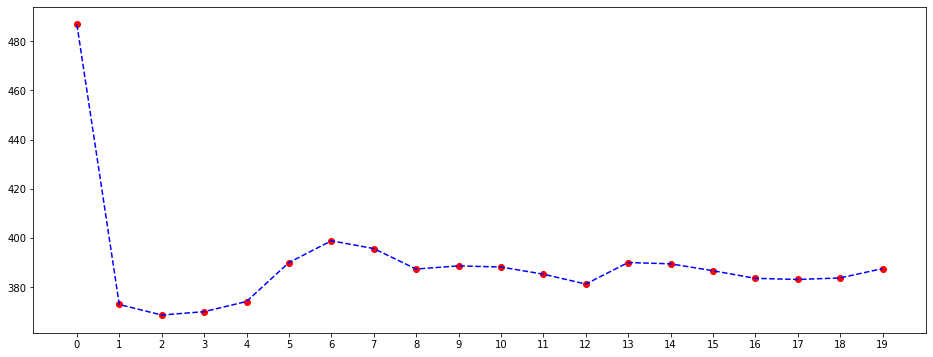

In [82]:
# > validationplot(pls.fit,val.type="MSEP")
plt.figure(figsize=(16, 6))
plt.plot(range(20),mean_score_list,'b--')
plt.scatter(range(20),mean_score_list, marker = 'o',color = 'r')
plt.xticks((range(20)))
plt.show()

In [83]:
grid_search.best_params_

{'n_components': 2}

In [84]:
mean_squared_error(grid_search.predict(X_test),y_test)

102583.13156134987

> pls.fit=plsr(Salary∼., data=Hitters ,scale=TRUE,ncomp=2)

> summary(pls.fit)

In [85]:
#续前TRAINING : % variance explained(这里结果与R相差较大，没弄清楚原因)
columns_names = []
for i in range(1,3):
    columns_names.append(str(i) + ' comps')
pls_var_exp = pd.DataFrame(columns = columns_names)
pls = PLSRegression(n_components = 2)
pls.fit(X ,y)
X_pls = pls.transform(X)
X_var_exp = []
for i in range(2):
    X_var_exp.append(((pls.transform(X)[:,i]**2).sum())/((scale(X) ** 2).sum()))
pls_var_exp.loc['X'] = (np.array(X_var_exp).cumsum()*100).round(2)
Salary_var_exp = []
for n_components in range(1,3):
    pls = PLSRegression(n_components = n_components)
    pls.fit(X ,y)
    Salary_var_exp.append(r2_score(y,pls.predict(X)))
pls_var_exp.loc['Salary'] = (np.array(Salary_var_exp)*100).round(2) 
pls_var_exp    

,1 comps,2 comps
X,37.29,45.6
Salary,43.05,46.4
